In [0]:
"""
Created on Tue June  5 12:34 2018
@author: Sibonelo Ngobese
"""
# Import libraries
import warnings
import os, cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

In [0]:
from keras import backend as K
K.set_image_dim_ordering('th')
#K.set_image_dim_ordering('tf')
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam

In [81]:
tf.__version__

'1.10.0'

In [82]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
#!ls -ltr drive/

In [0]:
#PATH = os.getcwd()
# Define data path
#data_path = PATH + '/data'
data_path = "drive/data/"
data_dir_list = os.listdir(data_path)

In [0]:
img_rows=128
img_cols=128
num_channel=1
num_epoch=10

In [85]:
img_data_list=[]
number_of_images_per_dir = []
dirnames = []
for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    counter = 0
    counter_list = []
    for img in img_list:
        if img != 'test':
            input_img= cv2.imread(data_path + '/'+ dataset + '/'+ img)           
            input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
            input_img_resize=cv2.resize(input_img,(128,128))#,interpolation=cv2.INTER_CUBIC)
            input_img_resize = input_img_resize/255
            img_data_list.append(input_img_resize)
            counter+=1
        counter_list.append(counter)
    number_of_images_per_dir.append(len(counter_list))
    dirnames.append(dataset)

Loaded the images of dataset-nimbus

Loaded the images of dataset-cirrus

Loaded the images of dataset-cumulus

Loaded the images of dataset-stratus



In [0]:
# Define the number of classes
num_classes = len(dirnames)

In [87]:
print("Class names are : ",dirnames)
print("Number of images per directory (respectively): ", number_of_images_per_dir)

Class names are :  ['nimbus', 'cirrus', 'cumulus', 'stratus']
Number of images per directory (respectively):  [145, 217, 190, 73]


In [88]:
img_data = np.array(img_data_list)
print (img_data.shape)

(621, 128, 128)


In [89]:
if num_channel==1:
	if K.image_dim_ordering()=='th':
		img_data= np.expand_dims(img_data, axis=1) 
		print (img_data.shape)
	else:
		img_data= np.expand_dims(img_data, axis=4) 
		print (img_data.shape)
		
else:
	if K.image_dim_ordering()=='th':
		img_data=np.rollaxis(img_data,3,1)
		print (img_data.shape)

(621, 1, 128, 128)


In [0]:
#%%
USE_SKLEARN_PREPROCESSING=False

if USE_SKLEARN_PREPROCESSING:
	# using sklearn for preprocessing
	from sklearn import preprocessing
	
	def image_to_feature_vector(image, size=(128, 128)):
		# resize the image to a fixed size, then flatten the image into
		# a list of raw pixel intensities
		return cv2.resize(image, size).flatten()
	
	img_data_list=[]
	for dataset in data_dir_list:
		img_list=os.listdir(data_path+'/'+ dataset)
		print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
		for img in img_list:
			if img != 'test':
				input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
				input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
				input_img_flatten=image_to_feature_vector(input_img,(128,128))
				img_data_list.append(input_img_flatten)
				
	img_data = np.array(img_data_list)
	img_data = img_data.astype('float32')
	print (img_data.shape)
	img_data_scaled = preprocessing.scale(img_data)
	print (img_data_scaled.shape)
	
	print (np.mean(img_data_scaled))
	print (np.std(img_data_scaled))
	
	print (img_data_scaled.mean(axis=0))
	print (img_data_scaled.std(axis=0))
	
	if K.image_dim_ordering()=='th':
		img_data_scaled=img_data_scaled.reshape(img_data.shape[0],num_channel,img_rows,img_cols)
		print (img_data_scaled.shape)
		
	else:
		img_data_scaled=img_data_scaled.reshape(img_data.shape[0],img_rows,img_cols,num_channel)
		print (img_data_scaled.shape)
	
	
	if K.image_dim_ordering()=='th':
		img_data_scaled=img_data_scaled.reshape(img_data.shape[0],num_channel,img_rows,img_cols)
		print (img_data_scaled.shape)
		
	else:
		img_data_scaled=img_data_scaled.reshape(img_data.shape[0],img_rows,img_cols,num_channel)
		print (img_data_scaled.shape)

In [0]:
if USE_SKLEARN_PREPROCESSING:
	img_data=img_data_scaled

In [92]:
#%%
# Assigning Labels

num_of_samples = img_data.shape[0]


print("n_images: ", num_of_samples)

n_images:  621


In [0]:
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:number_of_images_per_dir[0]-1]=0
labels[number_of_images_per_dir[0]-1:number_of_images_per_dir[0]+number_of_images_per_dir[1]-2]=1
labels[number_of_images_per_dir[0]+number_of_images_per_dir[1]-2:number_of_images_per_dir[0]+number_of_images_per_dir[1]+number_of_images_per_dir[2]-3]=2
labels[number_of_images_per_dir[0]+number_of_images_per_dir[1]+number_of_images_per_dir[2]-3:]=3

In [94]:
print("Shape of images: ",img_data.shape)

Shape of images:  (621, 1, 128, 128)


In [95]:
names = dirnames
print(names)
#e.g names = ['stratus', 'cirrus','cumulus','nimbus']

['nimbus', 'cirrus', 'cumulus', 'stratus']


In [0]:
# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [97]:
print(X_train.shape)

(496, 1, 128, 128)


In [0]:
#%%
# Defining the model
input_shape=img_data[0].shape

In [99]:
print(input_shape)

(1, 128, 128)


In [0]:
model = Sequential()

model.add(Convolution2D(32, 3,3,border_mode='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
#model.add(Convolution2D(64, 3, 3))
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [0]:
#sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=["accuracy"])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

In [102]:
# Viewing model_configuration
model.summary()
model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape			
model.layers[0].output_shape			
model.layers[0].get_weights()
np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 128, 128)      320       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 128, 128)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 126, 126)      9248      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 126, 126)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 63, 63)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 63, 63)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 61, 61)        18496     
__________

True

In [103]:
#%%
# Training
#hist = model.fit(X_train, y_train, batch_size=16, nb_epoch=num_epoch, verbose=1, validation_data=(X_test, y_test))

#hist = model.fit(X_train, y_train, batch_size=32, nb_epoch=20,verbose=1, validation_split=0.2)

# Training with callbacks
from keras import callbacks

filename='model_train_new.csv'
csv_log=callbacks.CSVLogger(filename, separator=',', append=False)

#early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='min')

filepath="Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#callbacks_list = [csv_log,early_stopping,checkpoint]
callbacks_list = [csv_log,checkpoint]

hist = model.fit(X_train, y_train, batch_size=16, epochs=num_epoch, verbose=1, validation_data=(X_test, y_test),callbacks=callbacks_list)

Train on 496 samples, validate on 125 samples
Epoch 1/10
496/496 [==============================] - 2s 4ms/step - loss: 1.5385 - acc: 0.3528 - val_loss: 1.3741 - val_acc: 0.3200

Epoch 00001: val_loss improved from inf to 1.37414, saving model to Best-weights-my_model-001-1.5385-0.3528.hdf5
Epoch 2/10
496/496 [==============================] - 2s 3ms/step - loss: 1.2999 - acc: 0.4012 - val_loss: 1.3458 - val_acc: 0.3840

Epoch 00002: val_loss improved from 1.37414 to 1.34576, saving model to Best-weights-my_model-002-1.2999-0.4012.hdf5
Epoch 3/10
496/496 [==============================] - 2s 3ms/step - loss: 1.2018 - acc: 0.5040 - val_loss: 1.2552 - val_acc: 0.4000

Epoch 00003: val_loss improved from 1.34576 to 1.25515, saving model to Best-weights-my_model-003-1.2018-0.5040.hdf5
Epoch 4/10
496/496 [==============================] - 2s 3ms/step - loss: 1.0640 - acc: 0.5685 - val_loss: 1.0495 - val_acc: 0.5600

Epoch 00004: val_loss improved from 1.25515 to 1.04947, saving model to Bes

In [0]:
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']

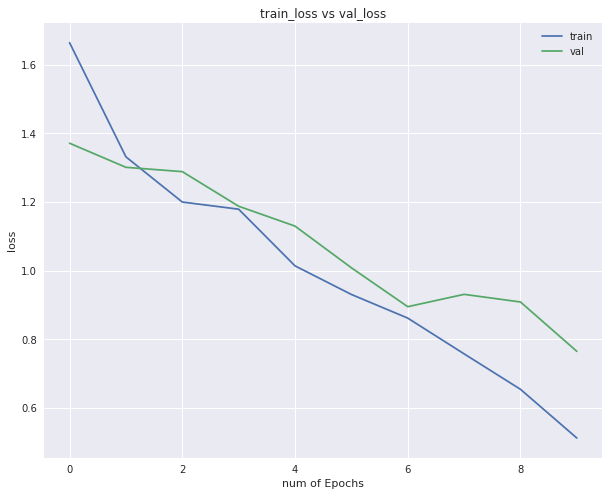

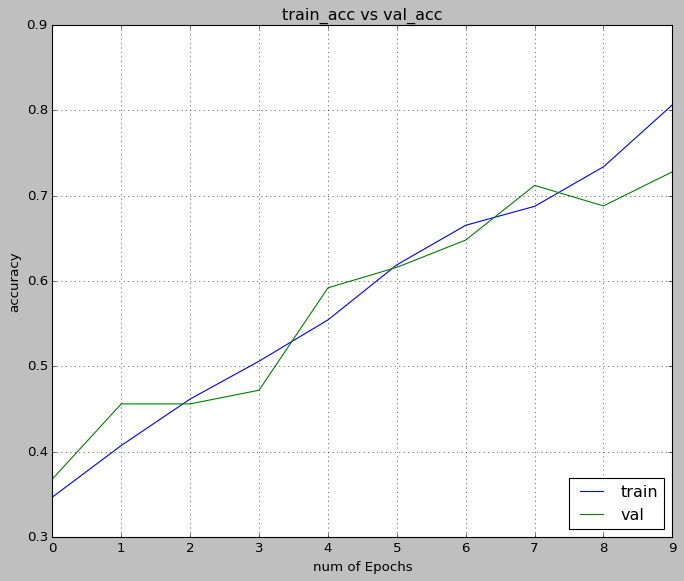

In [30]:
xc=range(num_epoch)

plt.figure(1,figsize=(10,8))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
#plt.savefig("train_loss_vs_val_los.png")
#plt.savefig("train_loss_vs_val_los.pdf")
#plt.cla()
plt.figure(2,figsize=(10,8))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
#plt.savefig("train_acc_vs_val_acc.png")
#plt.savefig("train_acc_vs_val_acc.pdf")
#%%

In [31]:
# Evaluating the model

score = model.evaluate(X_test, y_test, verbose=0)#show_accuracy=True, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

print(model.predict(test_image))
print(model.predict_classes(test_image))
print(y_test[0:1])

# Testing a new image
test_image = imread('drive/data/cumulus/test/cumulus_5_005.jpg')
test_image=cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
test_image=cv2.resize(test_image,(128,128))
test_image = np.array(test_image)
test_image = test_image.astype('float32')
test_image /= 255
print (test_image.shape)

Test Loss: 0.7649044890403748
Test accuracy: 0.7279999933242798
(1, 1, 128, 128)
[[0.00295015 0.04499923 0.94419914 0.00785143]]
[2]
[[0. 0. 1. 0.]]
(128, 128)


In [32]:
if num_channel==1:
	if K.image_dim_ordering()=='th':
		test_image= np.expand_dims(test_image, axis=0)
		test_image= np.expand_dims(test_image, axis=0)
		print (test_image.shape)
	else:
		test_image= np.expand_dims(test_image, axis=3) 
		test_image= np.expand_dims(test_image, axis=0)
		print (test_image.shape)
		
else:
	if K.image_dim_ordering()=='th':
		test_image=np.rollaxis(test_image,2,0)
		test_image= np.expand_dims(test_image, axis=0)
		print (test_image.shape)
	else:
		test_image= np.expand_dims(test_image, axis=0)
		print (test_image.shape)

(1, 1, 128, 128)


In [33]:
# Predicting the test image
print("test image predict probs:",(model.predict(test_image)))
print("test image predict class:", model.predict_classes(test_image))

test image predict probs: [[0.0075411  0.80494046 0.15760514 0.02991325]]
test image predict class: [1]


Now do this for all images in the test data. 

In [0]:
restored_imgs = model.predict_classes(X_test) # Class predictions highest probability means 

In [35]:

print(restored_imgs[0].shape, type(restored_imgs[0]))

() <class 'numpy.int64'>


In [0]:
def stringToImage(base64_string):
    import base64
    imgdata = base64.b64decode(base64_string)
    return Image.open(io.BytesIO(imgdata))
  
def toRGB(image):
    return cv2.cvtColor(np.array(image), cv2.COLOR_GRAY2BGR)

In [38]:
type(X_test[0].reshape(img_rows, img_cols))

numpy.ndarray

In [0]:
from PIL import Image
import matplotlib.cm as cm

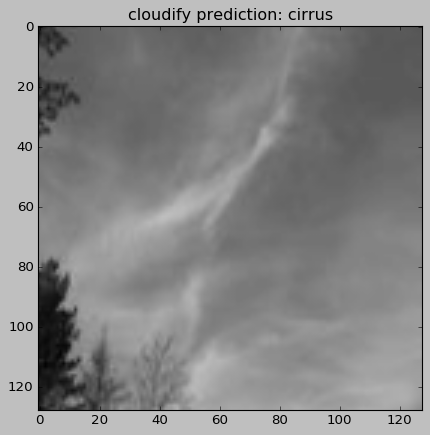

--------------------------------------------------------


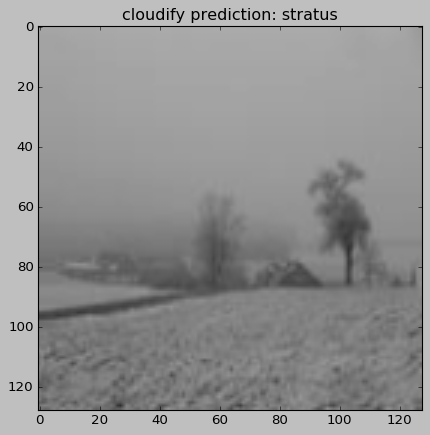

--------------------------------------------------------


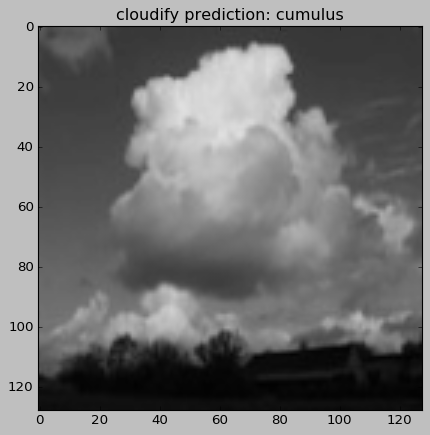

--------------------------------------------------------


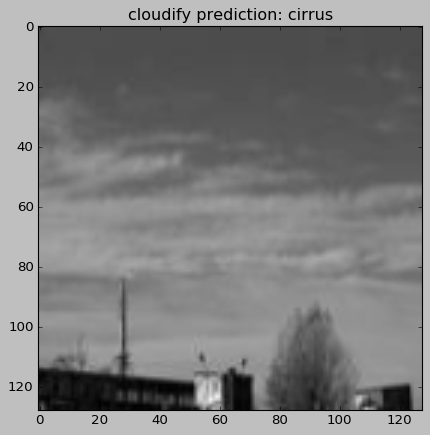

--------------------------------------------------------


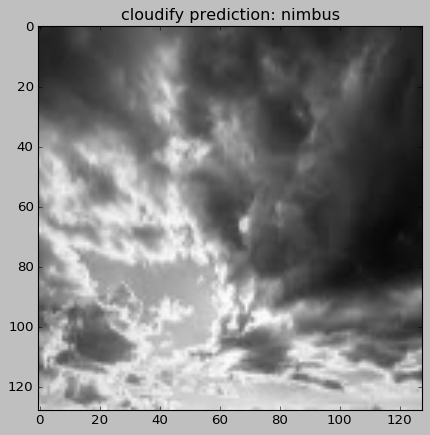

--------------------------------------------------------


In [52]:
for i in range(5):
    plt.title("cloudify prediction: {}".format(names[restored_imgs[i]]))
    plt.imshow( Image.fromarray(np.uint8( cm.gray( X_test[i].reshape(img_rows, img_cols) )*255) ) )
               
    #plt.gray()
    plt.show()
    
    
    print("--------------------------------------------------------")

In [0]:
pil_image = Image.fromarray(np.uint8( cm.gray( X_test[i].reshape(img_rows, img_cols) )*255))

In [57]:
type(np.asarray(pil_image))

numpy.ndarray

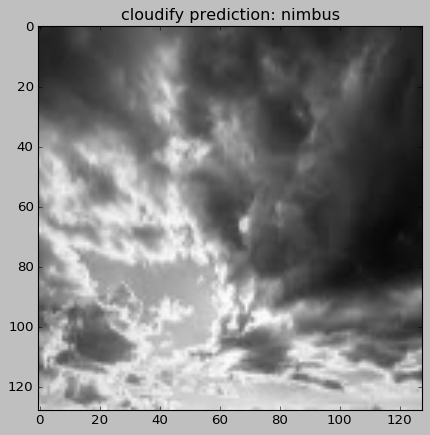

In [63]:
plt.title("cloudify prediction: {}".format(names[restored_imgs[4]]))
plt.imshow( np.asarray(pil_image) )
plt.show()

In [117]:
layers = len(model.layers)

for i in range(layers):
    print(i, ". ", model.layers[i].output.get_shape())

0 .  (?, 32, 128, 128)
1 .  (?, 32, 128, 128)
2 .  (?, 32, 126, 126)
3 .  (?, 32, 126, 126)
4 .  (?, 32, 63, 63)
5 .  (?, 32, 63, 63)
6 .  (?, 64, 61, 61)
7 .  (?, 64, 61, 61)
8 .  (?, 64, 30, 30)
9 .  (?, 64, 30, 30)
10 .  (?, ?)
11 .  (?, 64)
12 .  (?, 64)
13 .  (?, 64)
14 .  (?, 4)
15 .  (?, 4)


Can we ping this?

In [0]:
# Visualizing the intermediate layer

#
#def get_featuremaps(model, layer_idx, X_batch):
#	get_activations = K.function([model.layers[0].input, K.learning_phase()],[model.layers[layer_idx].output,])
#	activations = get_activations([X_batch,0])
#	return activations

#layer_num=3
#filter_num=0

#activations = get_featuremaps(model, int(layer_num),test_image)

#print (np.shape(activations))
#feature_maps = activations[0][0]      
#print (np.shape(feature_maps))

#if K.image_dim_ordering()=='th':
#	feature_maps=np.rollaxis((np.rollaxis(feature_maps,2,0)),2,0)
#print (feature_maps.shape)

#fig=plt.figure(figsize=(16,16))
#plt.imshow(np.array(feature_maps[:,:,int(filter_num)], dtype=np.int32),cmap='gray')
#plt.savefig("featuremaps-layer-{}".format(int(layer_num)) + "-filternum-{}".format(int(filter_num))+'.jpg')

#num_of_featuremaps=feature_maps.shape[2]
#fig=plt.figure(figsize=(16,16))	
#plt.title("featuremaps-layer-{}".format(layer_num))
#subplot_num=int(np.ceil(np.sqrt(num_of_featuremaps)))
#for i in range(int(num_of_featuremaps)):
#	ax = fig.add_subplot(subplot_num, subplot_num, i+1)
#	#ax.imshow(output_image[0,:,:,i],interpolation='nearest' ) #to see the first filter
#	ax.imshow(np.array(feature_maps[:,:,i], dtype=np.int32),cmap='gray')
#	plt.xticks([])
#	plt.yticks([])
#	plt.tight_layout()
#plt.show()
#fig.savefig("featuremaps-layer-{}".format(int(layer_num)) + '.jpg')

In [50]:
#%%
# Printing the confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = hist.predict(X_test)
print("predict probs for the whole test set:\n", Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
#y_pred = model.predict_classes(X_test)
#print(y_pred)
target_names =  ['class {}({})'.format(clsnum, clsname) for clsnum, clsname in enumerate(names)]

#e.g target_names = ['class 0(stratus)', 'class 1(cirrus)', class 2(cumulus)','class 3(nimbus)']
					
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))

print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))

predict probs for the whole test set:
 [[6.70635328e-02 2.62803942e-01 4.53972280e-01 2.16160238e-01]
 [5.52978992e-01 1.03510328e-01 1.45296887e-01 1.98213786e-01]
 [9.62613449e-02 8.26453447e-01 5.55826686e-02 2.17026118e-02]
 [4.41222787e-01 1.39424577e-01 2.97632307e-01 1.21720277e-01]
 [4.38035190e-01 1.37075752e-01 3.02894086e-01 1.21994980e-01]
 [1.33713394e-01 3.38529170e-01 3.12822193e-01 2.14935169e-01]
 [1.42959699e-01 2.33845428e-01 2.89333850e-01 3.33861083e-01]
 [9.56890881e-02 7.75100112e-01 1.22010089e-01 7.20072817e-03]
 [2.51763705e-02 2.74469983e-02 8.44810963e-01 1.02565713e-01]
 [1.92022398e-02 9.40938175e-01 3.54993008e-02 4.36023297e-03]
 [5.77615350e-02 4.71852660e-01 4.20810074e-01 4.95756716e-02]
 [3.36312316e-02 6.59101456e-02 1.47982612e-01 7.52476037e-01]
 [3.53836119e-01 4.56523776e-01 8.14359039e-02 1.08204208e-01]
 [2.26658255e-01 6.18550241e-01 1.20127738e-01 3.46637405e-02]
 [1.90253723e-02 6.44453168e-02 1.46385893e-01 7.70143449e-01]
 [4.30877283e-02

In [0]:
# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))

np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[18  5  0  2]
 [ 0 37  2  1]
 [ 3  7 36  2]
 [ 0  0  3  9]]


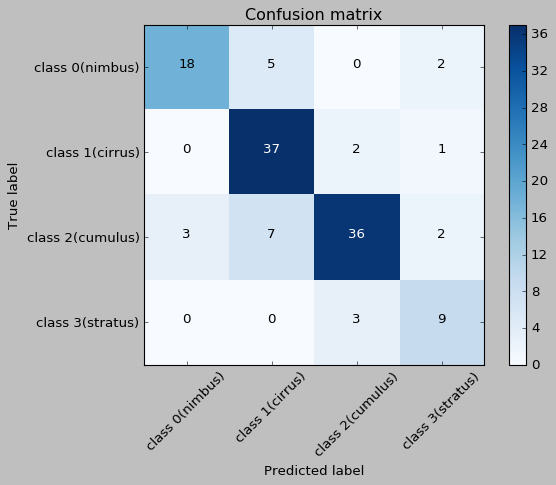

In [52]:
plt.figure()

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')
#plt.figure()
# Plot normalized confusion matrix
#plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
#                      title='Normalized confusion matrix')
#plt.figure()
#plt.show()
#plt.savefig("confusion_matrix.png")
#plt.savefig("confusion_matrix.pdf")

In [0]:
#%%
# Saving and loading model and weights
#from keras.models import model_from_json
#from keras.models import load_model

# serialize model to JSON
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
#    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("model.h5")
#print("Saved model to disk")

# load json and create model
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")

#model.save('model.hdf5')
#loaded_model=load_model('model.hdf5')